In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



118/118 [==============================] - 0s 2ms/step
Dataset: walmart_stock_price, Train-Test Ratio = 0.7:0.3
Root Mean Squared Error (RMSE): 4.053246457209276
Mean Absolute Percentage Error (MAPE): 38.288996812934144
Mean Absolute Error (MAE): 2.2447649854183953


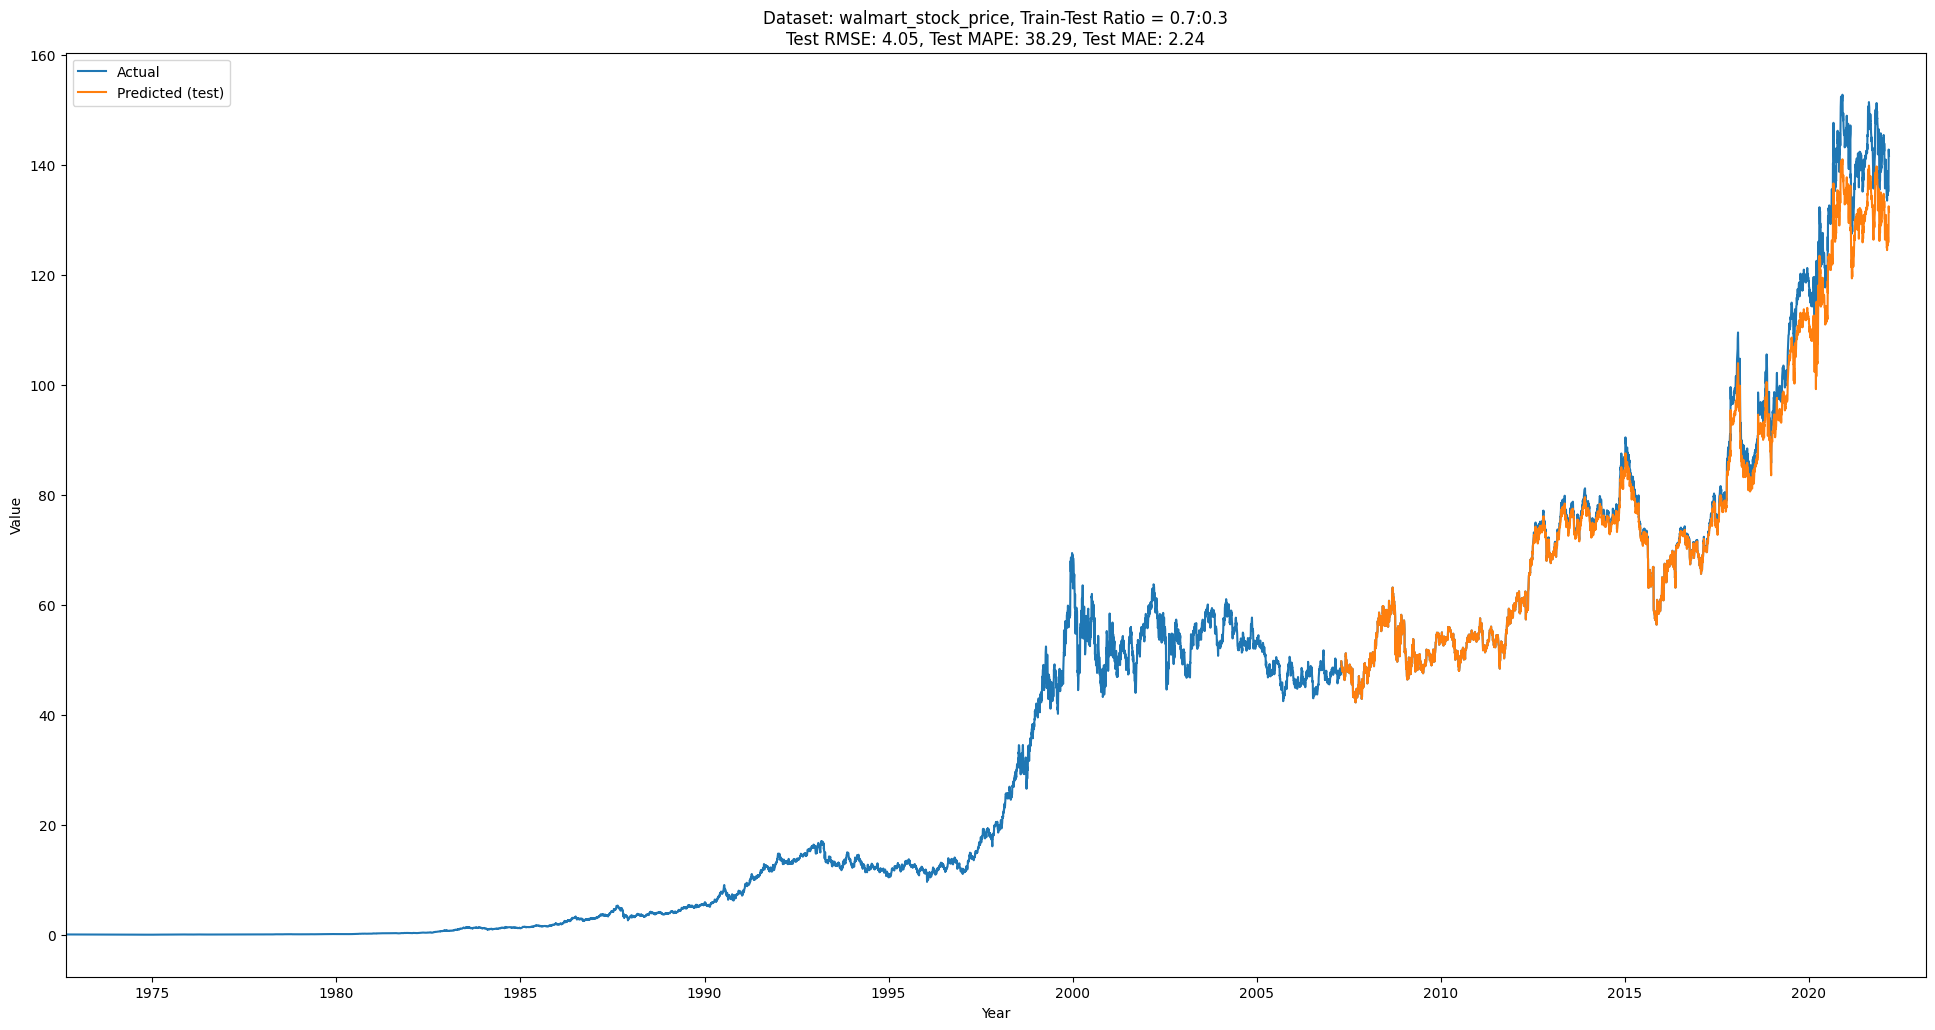



79/79 [==============================] - 0s 2ms/step
Dataset: walmart_stock_price, Train-Test Ratio = 0.8:0.2
Root Mean Squared Error (RMSE): 4.7220185557589085
Mean Absolute Percentage Error (MAPE): 28.798390536341916
Mean Absolute Error (MAE): 3.26196892843866


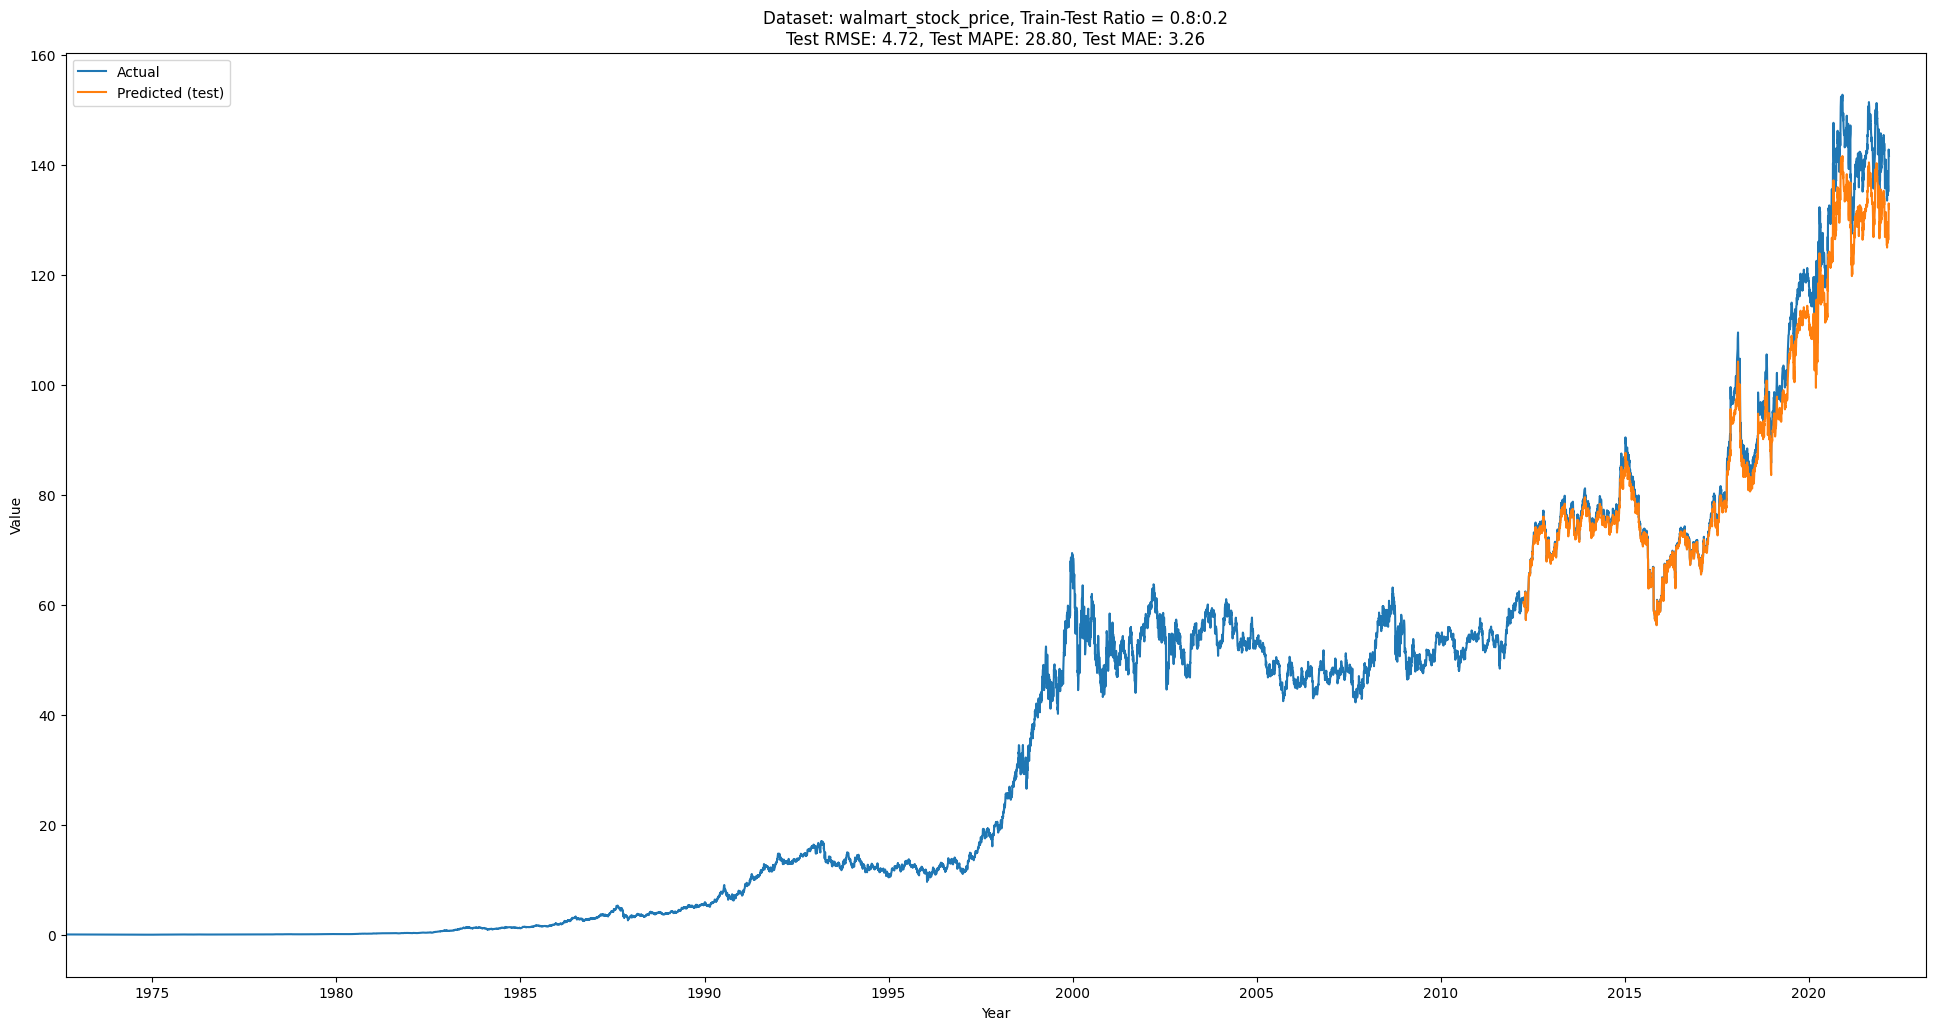



40/40 [==============================] - 0s 2ms/step
Dataset: walmart_stock_price, Train-Test Ratio = 0.9:0.1
Root Mean Squared Error (RMSE): 4.405893104969523
Mean Absolute Percentage Error (MAPE): 23.818367742426567
Mean Absolute Error (MAE): 3.337467902671094


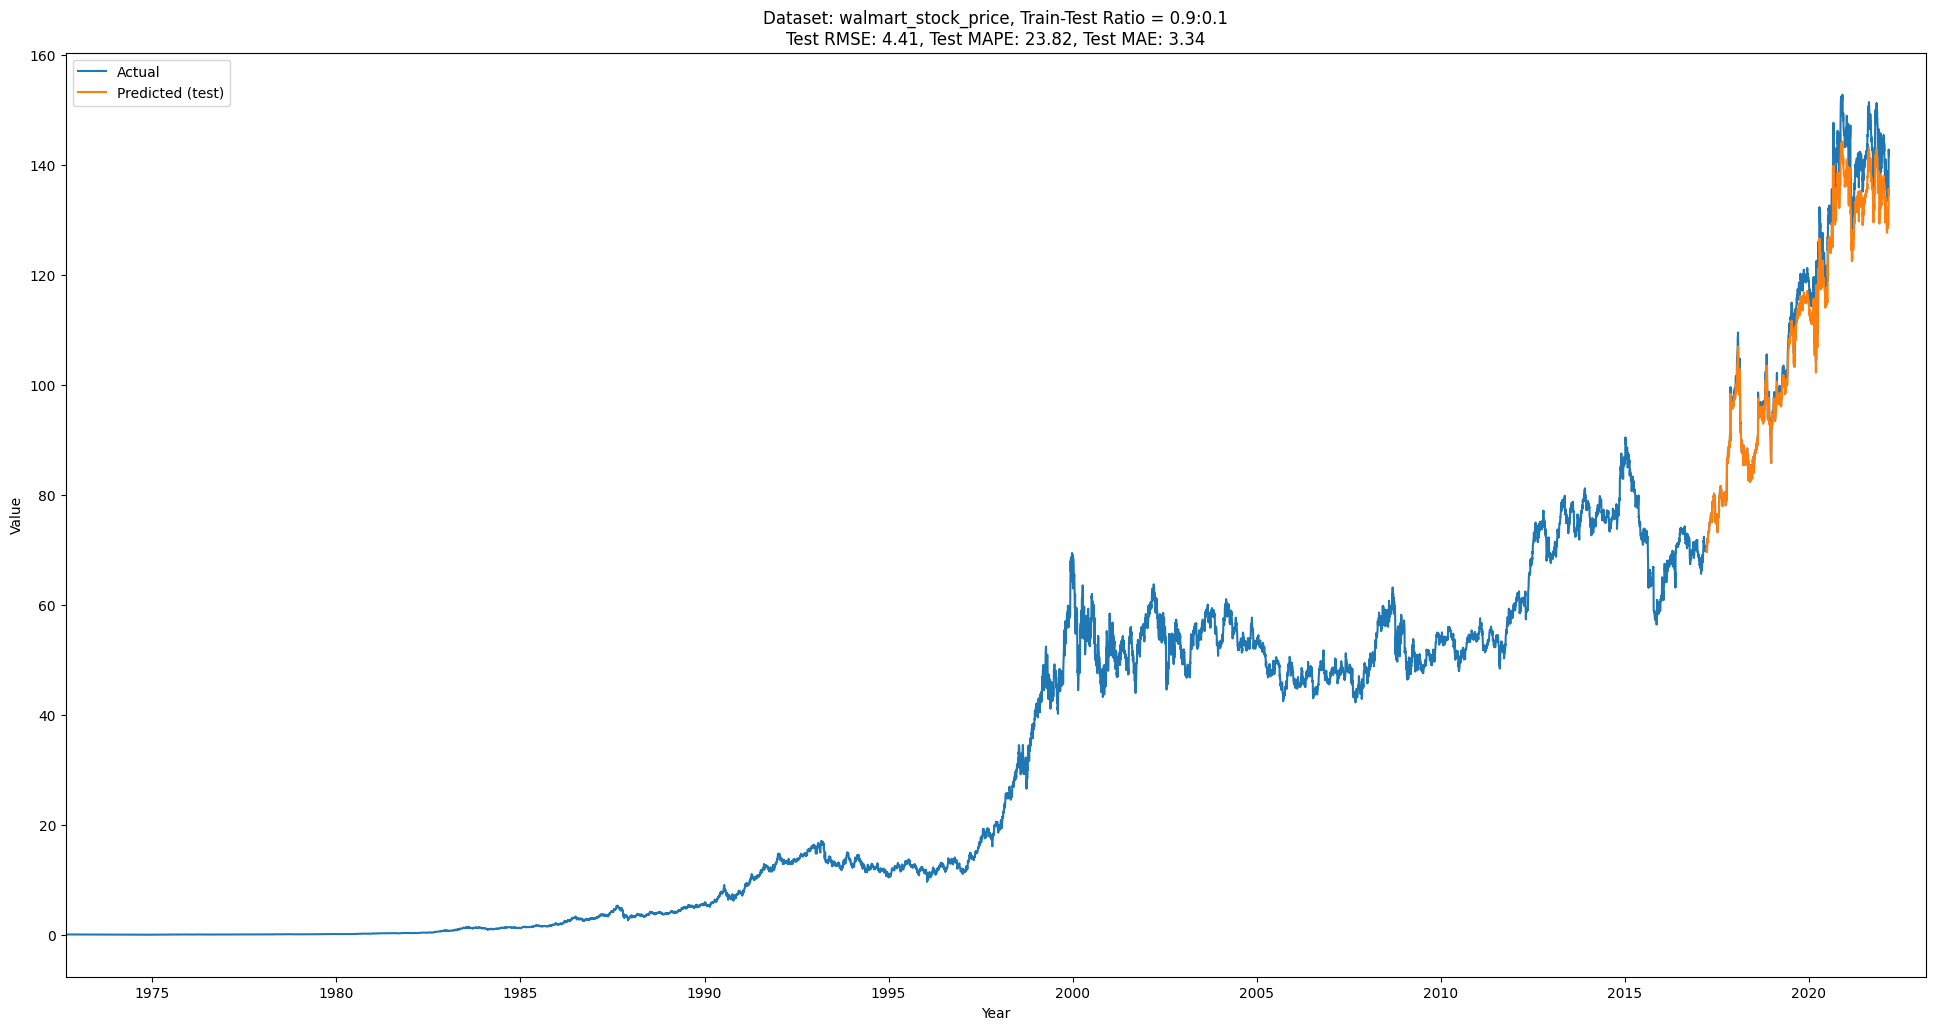



24/24 [==============================] - 0s 2ms/step
Dataset: facebook_stock_price, Train-Test Ratio = 0.7:0.3
Root Mean Squared Error (RMSE): 8.388743122846565
Mean Absolute Percentage Error (MAPE): 27.538240339179442
Mean Absolute Error (MAE): 5.701582045987694


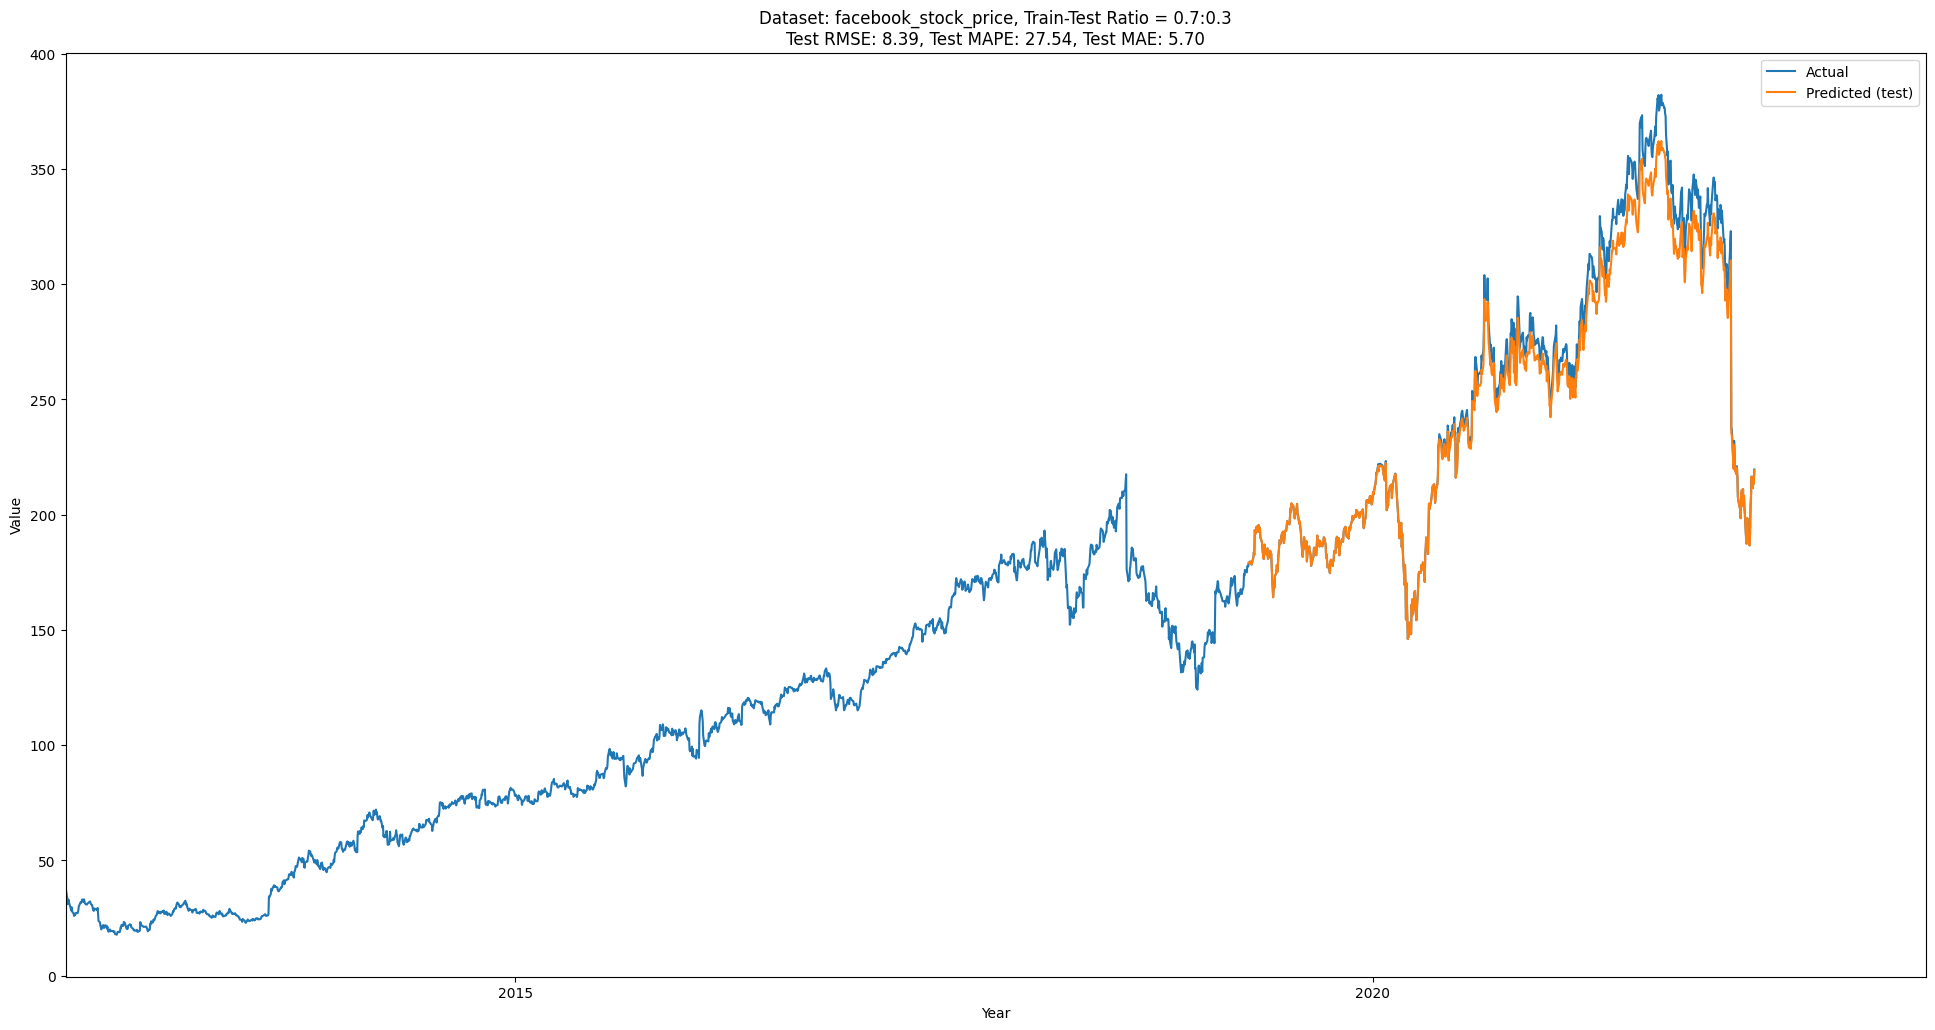



16/16 [==============================] - 0s 4ms/step
Dataset: facebook_stock_price, Train-Test Ratio = 0.8:0.2
Root Mean Squared Error (RMSE): 12.86110750412778
Mean Absolute Percentage Error (MAPE): 19.98781724400784
Mean Absolute Error (MAE): 10.448012544583227


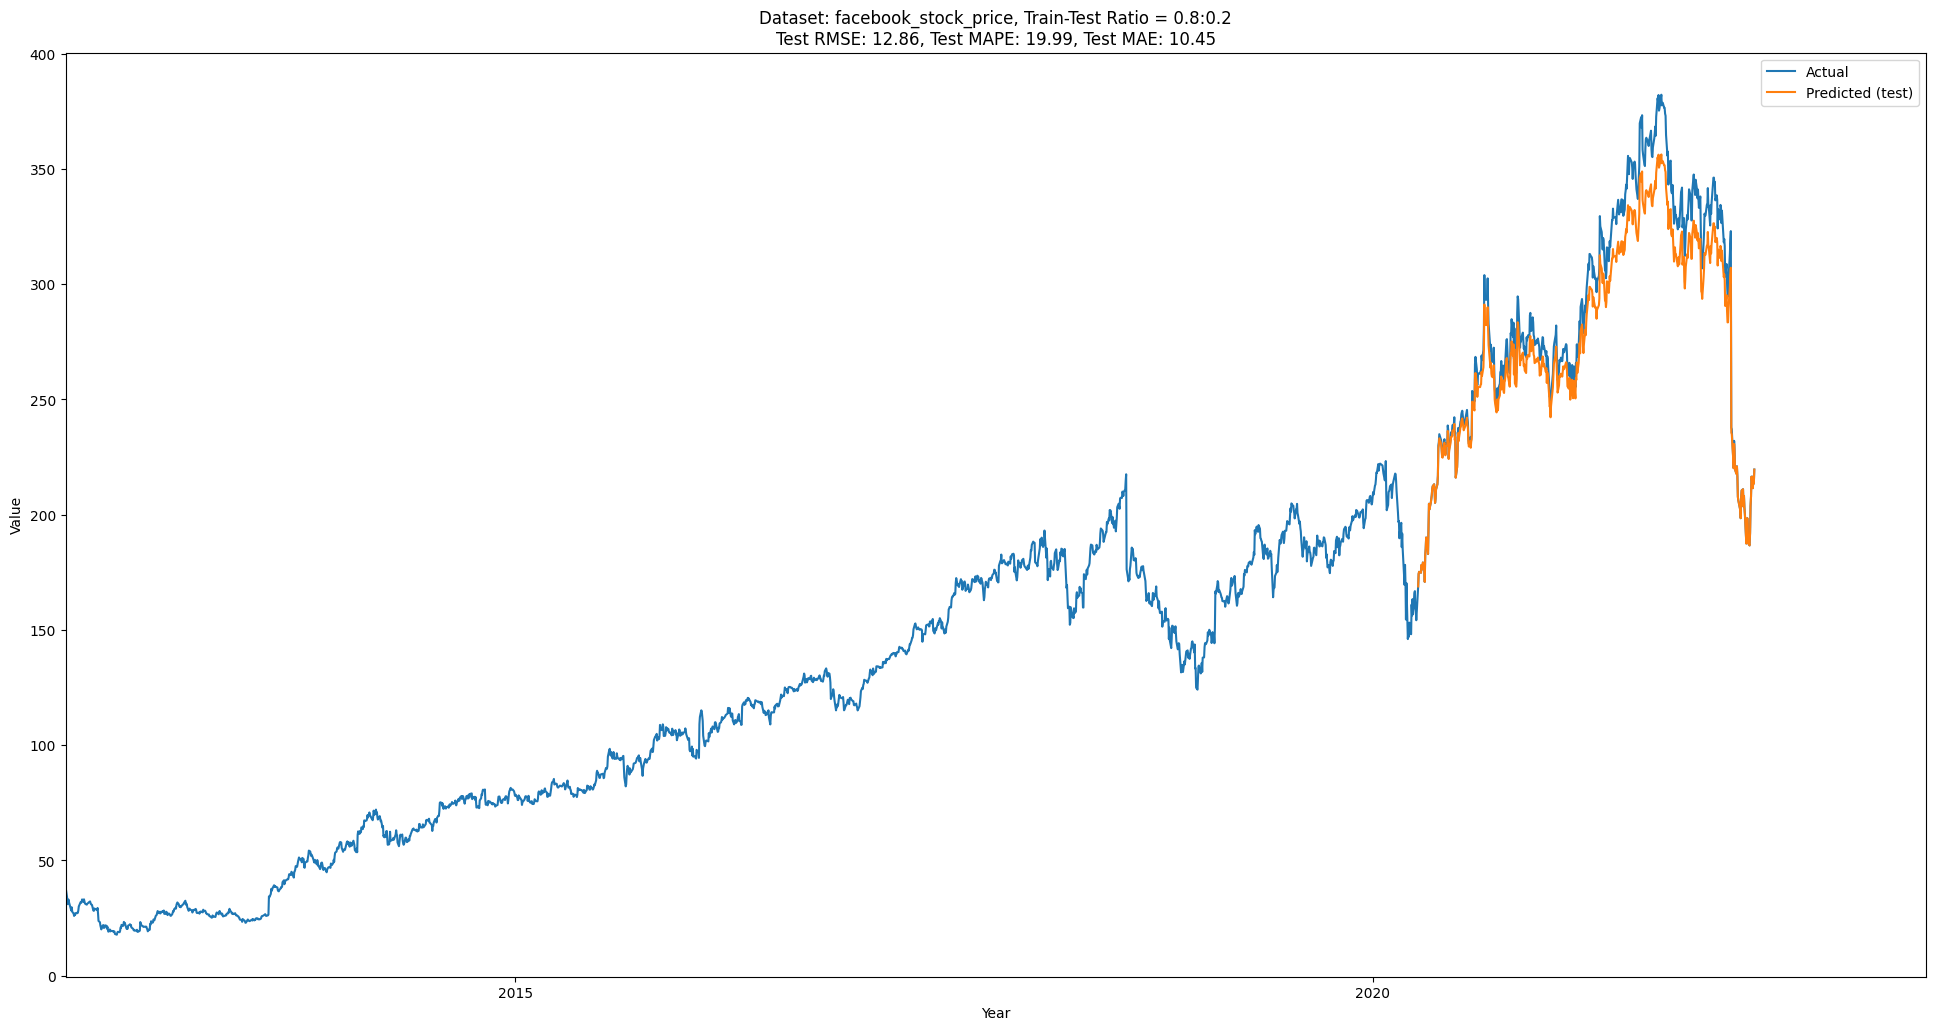



8/8 [==============================] - 0s 5ms/step
Dataset: facebook_stock_price, Train-Test Ratio = 0.9:0.1
Root Mean Squared Error (RMSE): 5.167296827380827
Mean Absolute Percentage Error (MAPE): 16.60610073570428
Mean Absolute Error (MAE): 4.069495237237747


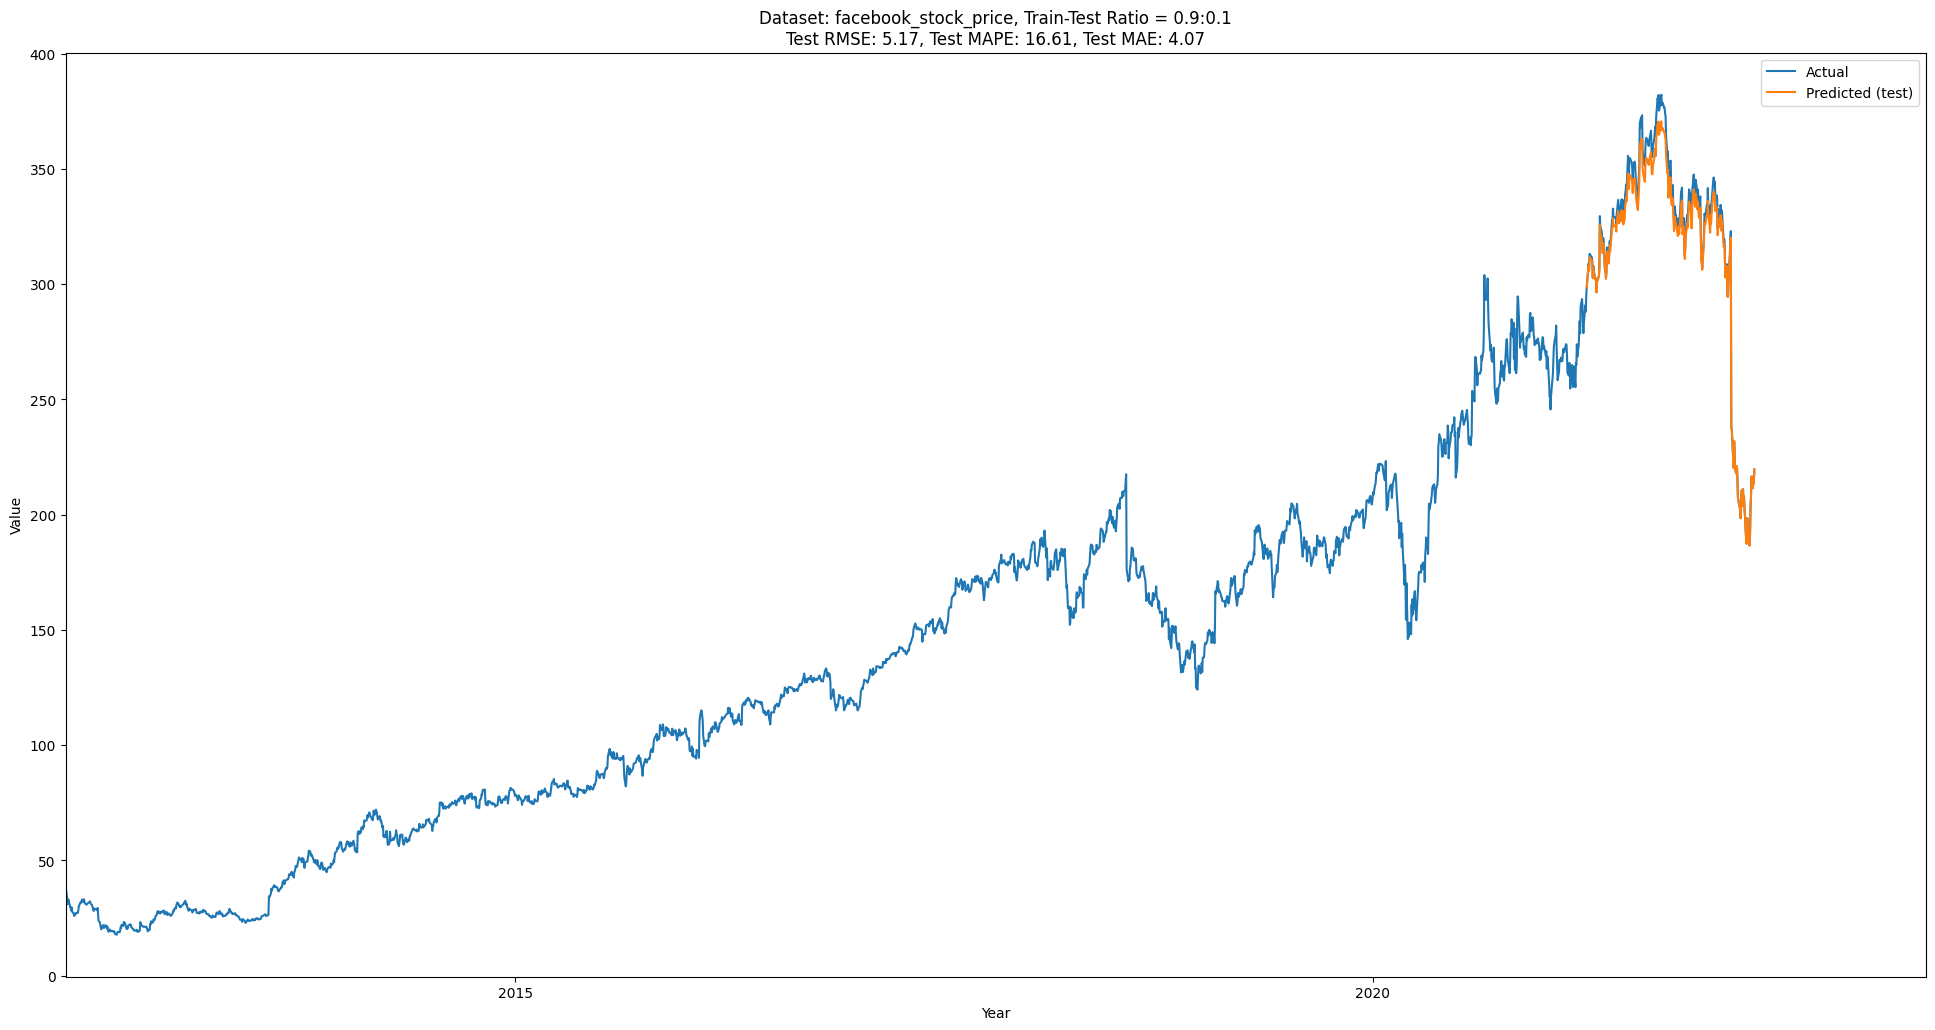



28/28 [==============================] - 0s 2ms/step
Dataset: tesla_stock_price, Train-Test Ratio = 0.7:0.3
Root Mean Squared Error (RMSE): 36.3381633264504
Mean Absolute Percentage Error (MAPE): 268.1527874085368
Mean Absolute Error (MAE): 24.54180732219048


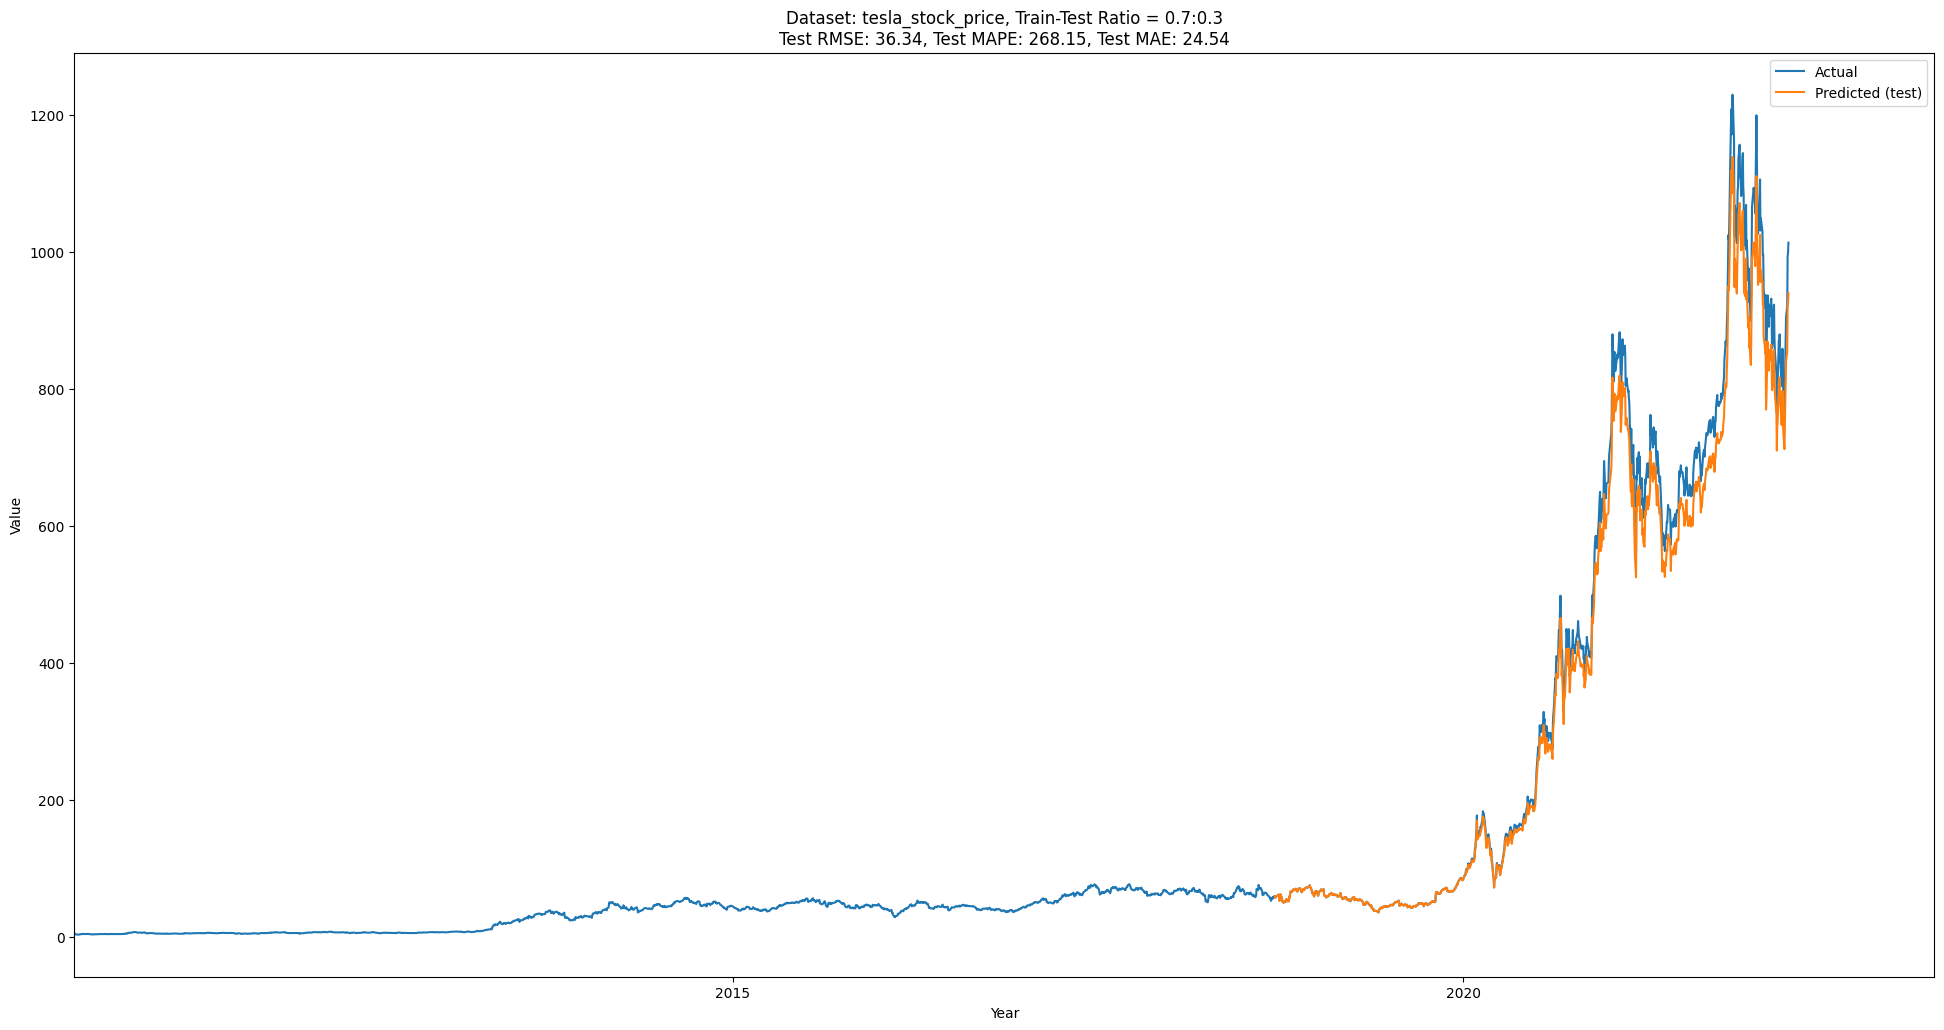



19/19 [==============================] - 0s 5ms/step
Dataset: tesla_stock_price, Train-Test Ratio = 0.8:0.2
Root Mean Squared Error (RMSE): 58.933337853794505
Mean Absolute Percentage Error (MAPE): 126.7127071529816
Mean Absolute Error (MAE): 48.76709556980525


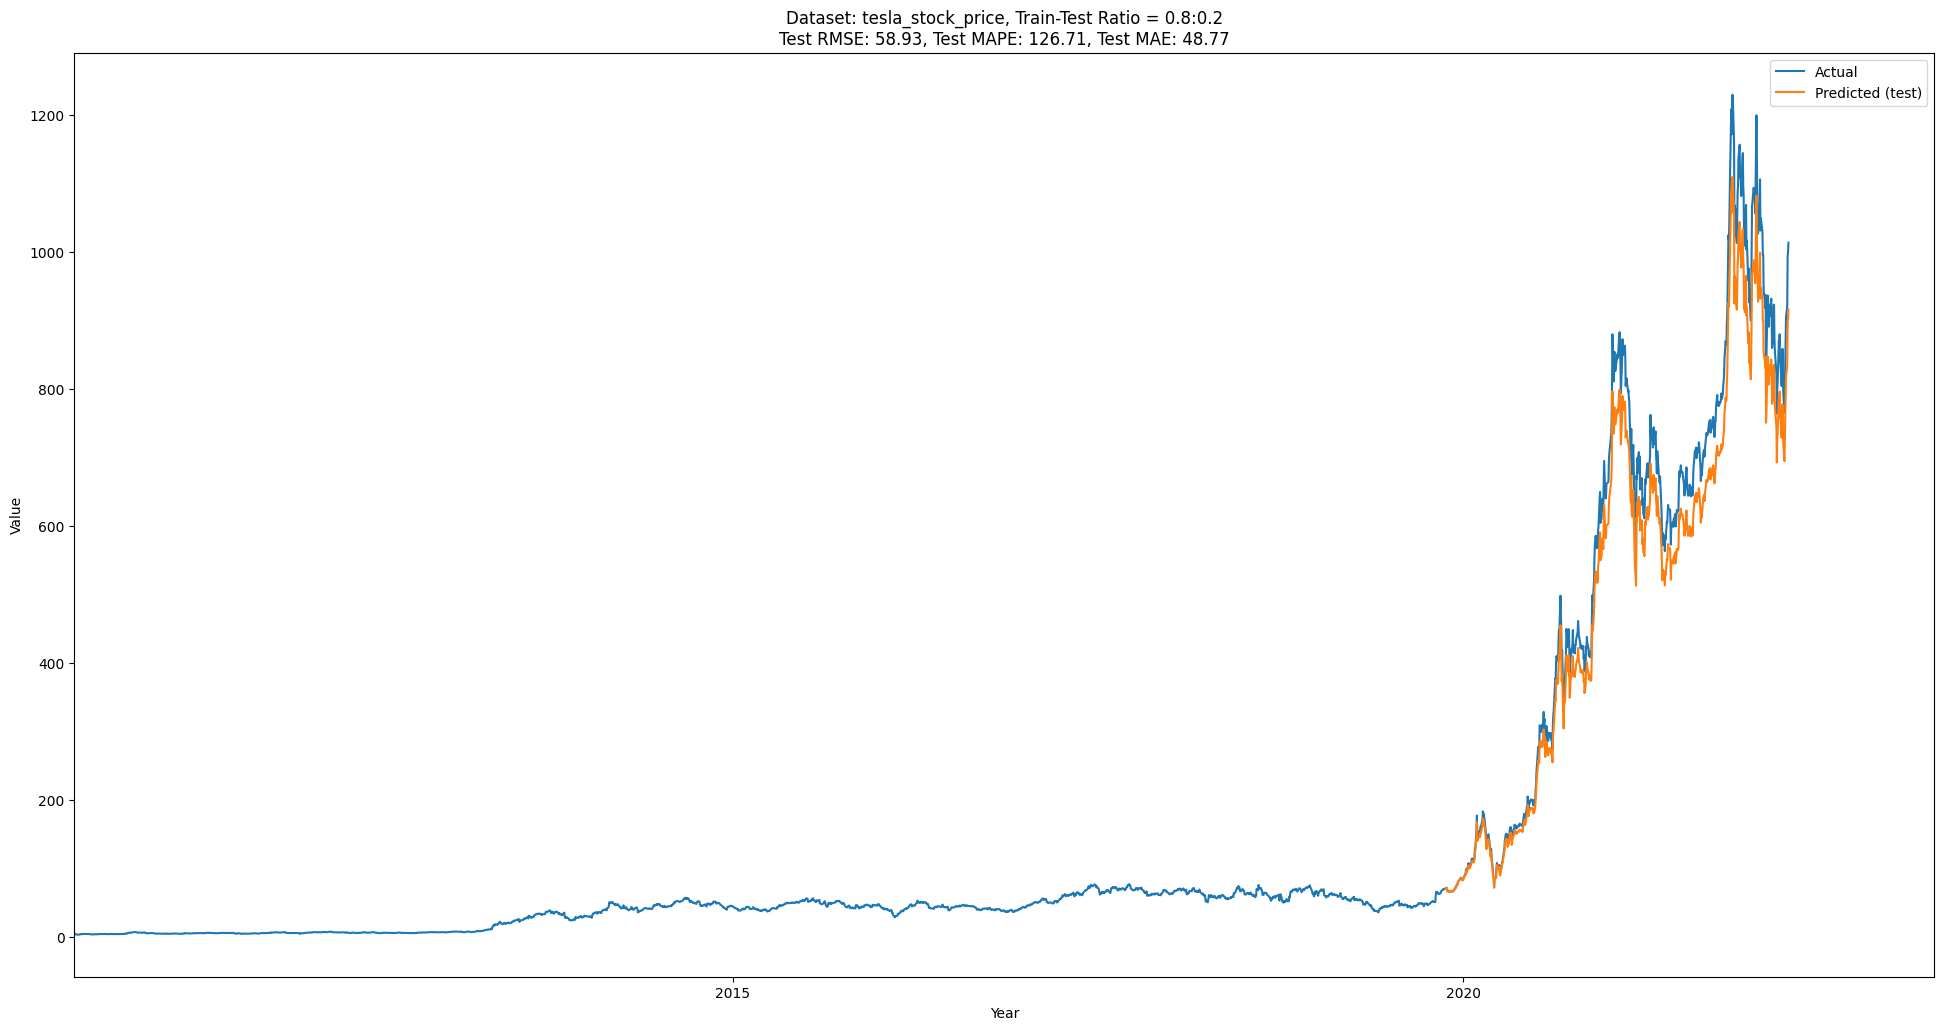



10/10 [==============================] - 0s 3ms/step
Dataset: tesla_stock_price, Train-Test Ratio = 0.9:0.1
Root Mean Squared Error (RMSE): 1.2055142574582864
Mean Absolute Percentage Error (MAPE): 22.83292279706171
Mean Absolute Error (MAE): 0.8143409382786131


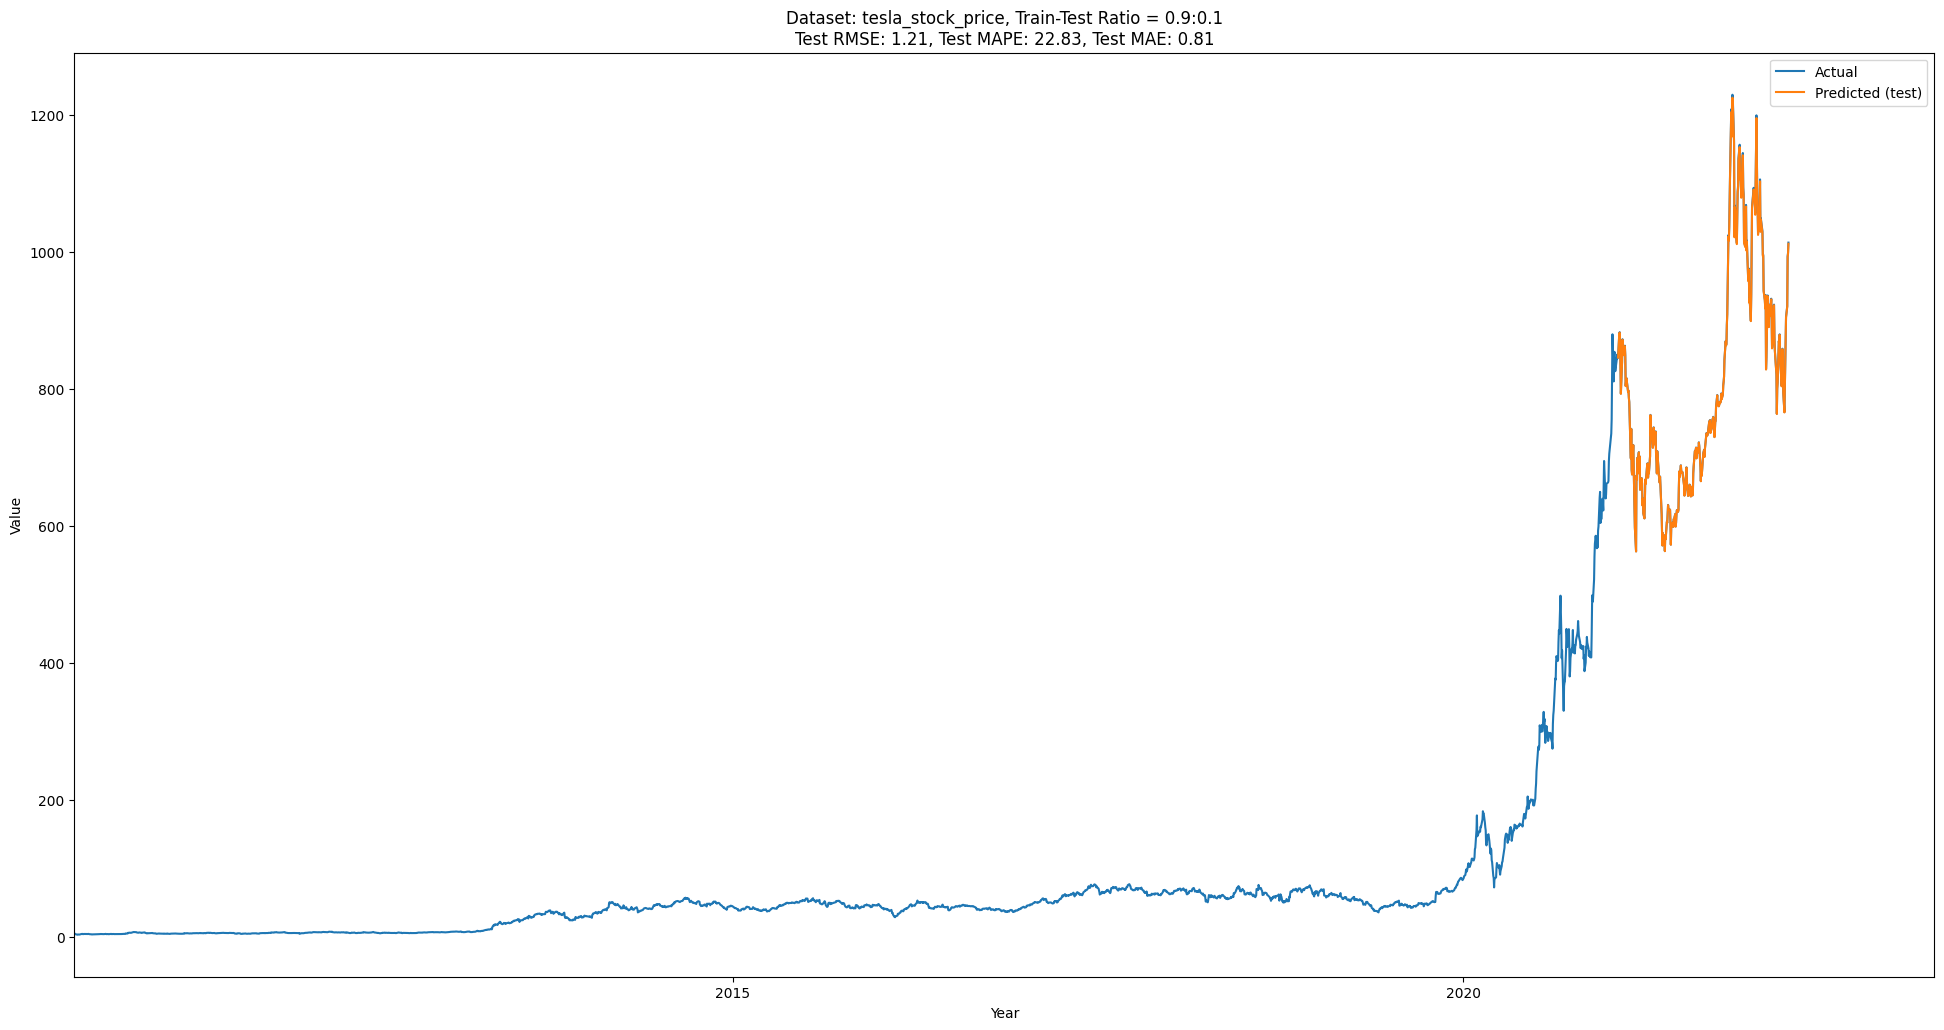

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def train_test_model(dataset_url, train_ratio):
    # Load dataset
    df = pd.read_csv(dataset_url, parse_dates=['Date'], index_col='Date')

    # Split train-test data
    train_size = int(len(df) * train_ratio)
    test_size = len(df) - train_size
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # Normalize data
    scaler = StandardScaler()
    train_data_norm = scaler.fit_transform(train_data)
    test_data_norm = scaler.transform(test_data)

    # Build and compile the model
    inputs = Input(shape=(train_data_norm.shape[1], 1))
    conv1 = Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu')(inputs)
    conv2 = Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=2, activation='relu')(conv1)
    conv3 = Conv1D(filters=128, kernel_size=3, padding='causal', dilation_rate=4, activation='relu')(conv2)
    gap = GlobalAveragePooling1D()(conv3)
    outputs = Dense(1)(gap)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train the model
    model.fit(train_data_norm.reshape(-1, train_data_norm.shape[1], 1), train_data_norm[:, -1],
              epochs=10, batch_size=32, verbose=0)

    # Make predictions on the test data
    test_pred = scaler.inverse_transform(model.predict(test_data_norm.reshape(-1, test_data_norm.shape[1], 1)))

    # Print the title for the case
    print(f"Dataset: {dataset_url.split('/')[-1].split('.')[0]}, Train-Test Ratio = {train_ratio}:{round(1 - train_ratio, 1)}")
    # Calculate evaluation metrics
    test_rmse = np.sqrt(mean_squared_error(test_data.iloc[:, -1], test_pred))
    test_mape = np.mean(np.abs((test_data.iloc[:, -1].values - test_pred) / test_data.iloc[:, -1].values)) * 100
    test_mae = mean_absolute_error(test_data.iloc[:, -1], test_pred)
    print("Root Mean Squared Error (RMSE):", test_rmse)
    print("Mean Absolute Percentage Error (MAPE):", test_mape)
    print("Mean Absolute Error (MAE):", test_mae)

    # Plot actual vs predicted values
    df.index = pd.to_datetime(df.index)
    fig, ax = plt.subplots(figsize=(24, 12))
    plt.plot(df.index, df.iloc[:, -1].values, label='Actual')
    plt.plot(test_data.index, test_pred[:, -1], label='Predicted (test)')
    plt.title(f"Dataset: {dataset_url.split('/')[-1].split('.')[0]}, Train-Test Ratio = {train_ratio}:{round(1 - train_ratio, 1)}\n"
              f"Test RMSE: {test_rmse:.2f}, Test MAPE: {test_mape:.2f}, Test MAE: {test_mae:.2f}")
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.xlim(df.index[0], df.index[-1] + pd.DateOffset(years=1))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
    plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.YearLocator(base=5)))
    plt.show()


# Define the datasets
datasets = [
    'https://raw.githubusercontent.com/huy164/datasets/master/walmart_stock_price.csv',
    'https://raw.githubusercontent.com/huy164/datasets/master/facebook_stock_price.csv',
    'https://raw.githubusercontent.com/huy164/datasets/master/tesla_stock_price.csv'
]

# Define the train-test ratios
ratios = [0.7, 0.8, 0.9]

# Run the logic for each dataset with each ratio
for dataset_url in datasets:
    for ratio in ratios:
        train_test_model(dataset_url, ratio)
        print("\n")
